In [1]:
!pip install statsmodels
!pip install xgboost
!pip install lightgbm
!pip install catboost

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn

In [3]:
from sklearn.model_selection import GridSearchCV, train_test_split

# Import Classifier Model
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.svm import SVC # Support Vector Machine
from sklearn.naive_bayes import GaussianNB # Import Gaussian Naive Bayes
from sklearn.naive_bayes import MultinomialNB # Import Multinomial Naive Bayes
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent
from sklearn.neighbors import KNeighborsClassifier # K Nearest Neighbor
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier # Random Forest
from xgboost.sklearn import XGBClassifier #XGBoost

# Import Regressor Model
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [4]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [5]:
print(tf.__version__)

2.8.2


In [93]:
df = pd.read_csv('../self/df_pre.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54480 entries, 0 to 54479
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   remote_user          54480 non-null  object 
 1   hostname             54480 non-null  object 
 2   status               54480 non-null  int64  
 3   body_bytes_sent      54480 non-null  int64  
 4   request_method       54480 non-null  object 
 5   request_length       54480 non-null  int64  
 6   bytes_sent           54480 non-null  int64  
 7   request_time         54480 non-null  float64
 8   upstream_status      54480 non-null  int64  
 9   connection           54480 non-null  int64  
 10  connection_requests  54480 non-null  int64  
 11  agent.ip             54480 non-null  object 
 12  rule.mitre.tactic    54480 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usage: 5.4+ MB


In [110]:
df['rule.mitre.tactic'].value_counts()

0    52101
1     1784
3      561
2       29
5        4
4        1
Name: rule.mitre.tactic, dtype: int64

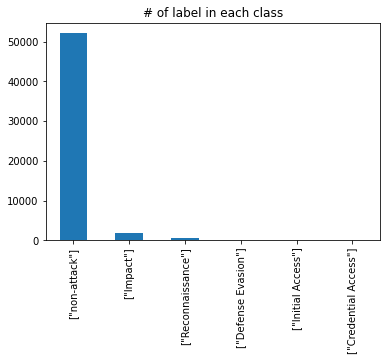

In [94]:
df['rule.mitre.tactic'].value_counts().plot(kind='bar')
plt.title('# of label in each class')
plt.show()

In [95]:
for col in df:
    print(f'Unique value in col {col} ({df[col].dtype}) - {df[col].nunique()}')

Unique value in col remote_user (object) - 3
Unique value in col hostname (object) - 1
Unique value in col status (int64) - 14
Unique value in col body_bytes_sent (int64) - 816
Unique value in col request_method (object) - 3
Unique value in col request_length (int64) - 1194
Unique value in col bytes_sent (int64) - 973
Unique value in col request_time (float64) - 1073
Unique value in col upstream_status (int64) - 14
Unique value in col connection (int64) - 46530
Unique value in col connection_requests (int64) - 551
Unique value in col agent.ip (object) - 1
Unique value in col rule.mitre.tactic (object) - 6


In [96]:
df[df['rule.mitre.tactic'] == '["Credential Access"]']

,remote_user,hostname,status,body_bytes_sent,request_method,request_length,bytes_sent,request_time,upstream_status,connection,connection_requests,agent.ip,rule.mitre.tactic
22171,-,vm-director-nginx,200,956,POST,684,1224,0.006,200,701008974,1,192.168.1.99,"[""Credential Access""]"


In [97]:
df['status'].unique()

array([404, 502, 200, 400, 422, 500, 407, 403, 504, 303, 302, 301, 405,
       413])

In [98]:
df['remote_user'].unique()

array(['-', 'GapuraUb2020-Mobile', 'google-oauth-client'], dtype=object)

In [99]:
df['request_method'].unique()

array(['GET', 'POST', 'HEAD'], dtype=object)

In [100]:
df['rule.mitre.tactic'].unique()

array(['["non-attack"]', '["Impact"]', '["Defense Evasion"]',
       '["Reconnaissance"]', '["Credential Access"]',
       '["Initial Access"]'], dtype=object)

In [101]:
# Drop unnecessary column
df.drop(['hostname', 'agent.ip', ], axis=1, inplace=True)

In [102]:
# Encode categorical column
encode_remote_user = {
    '-': 0,
    'GapuraUb2020-Mobile': 1,
    'google-oauth-client': 2
}

encode_req_method = {
    'GET': 0,
    'POST': 1,
    'HEAD': 2
}

encode_label = {
    '["non-attack"]': 0,
    '["Impact"]': 1,
    '["Defense Evasion"]': 2,
    '["Reconnaissance"]': 3,
    '["Credential Access"]': 4,
    '["Initial Access"]': 5
}

df['remote_user'] = df['remote_user'].apply(lambda x: encode_remote_user[x])
df['request_method'] = df['request_method'].apply(lambda x: encode_req_method[x])
df['rule.mitre.tactic'] = df['rule.mitre.tactic'].apply(lambda x: encode_label[x])

def preprocess(df):
    df.drop(['hostname', 'agent.ip', ], axis=1, inplace=True)
    df['remote_user'] = df['remote_user'].apply(lambda x: encode_remote_user[x])
    df['request_method'] = df['request_method'].apply(lambda x: encode_req_method[x])
    df['rule.mitre.tactic'] = df['rule.mitre.tactic'].apply(lambda x: encode_label[x])
    return df

In [103]:
df.head()

,remote_user,status,body_bytes_sent,request_method,request_length,bytes_sent,request_time,upstream_status,connection,connection_requests,rule.mitre.tactic
0,0,404,118,0,79,330,0.002,404,688306444,2,0
1,0,404,118,0,79,330,0.002,404,688306865,2,0
2,0,404,118,0,92,330,0.003,404,688306855,2,0
3,0,404,118,0,81,330,0.002,404,688306869,2,0
4,0,404,118,0,82,330,0.003,404,688307225,2,0


In [104]:
for col in df:
    print(f'Unique value in col {col} ({df[col].dtype}) - {df[col].nunique()}')

Unique value in col remote_user (int64) - 3
Unique value in col status (int64) - 14
Unique value in col body_bytes_sent (int64) - 816
Unique value in col request_method (int64) - 3
Unique value in col request_length (int64) - 1194
Unique value in col bytes_sent (int64) - 973
Unique value in col request_time (float64) - 1073
Unique value in col upstream_status (int64) - 14
Unique value in col connection (int64) - 46530
Unique value in col connection_requests (int64) - 551
Unique value in col rule.mitre.tactic (int64) - 6


In [105]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [108]:
def evaluate_classifier_model(X_train, X_test, y_train, y_test):
    from sklearn.linear_model import LogisticRegression # Logistic Regression
    from sklearn.svm import SVC # Support Vector Machine
    from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bayes
    from sklearn.naive_bayes import MultinomialNB # Multinomial Naive Bayes
    from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent
    from sklearn.neighbors import KNeighborsClassifier # K Nearest Neighbor
    from sklearn.tree import DecisionTreeClassifier # Decision Tree Classifier
    from sklearn.ensemble import RandomForestClassifier # Random Forest
    from xgboost.sklearn import XGBClassifier #XGBoost

    models = {
          'LogisticRegression': LogisticRegression(),
          'DecisionTreeClassifier': DecisionTreeClassifier(),
          'RandomForestClassifier': RandomForestClassifier(),
          'GaussianNB': GaussianNB(),
          'MultinomialNB': MultinomialNB(),
          'SVC': SVC(),
          'SGDClassifier': SGDClassifier(),
          'KNeighborsClassifier': KNeighborsClassifier(),
          'XGBClassifier': XGBClassifier()
      }
    models_score = {}

    for name, model in models.items():
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = f1_score(y_test, y_pred, average='weighted')
            print(f'Accuracy score for {name}: {score}')
            models_score[name] = score
        except Exception as e:
            print(f'model {name} can\'t be trained')
            print(e)

    return pd.Series(models_score).sort_values(ascending=False)

def evaluate_regressor_model(X_train, X_test, y_train, y_test):
    from sklearn.linear_model import LinearRegression
    from lightgbm import LGBMRegressor
    from xgboost.sklearn import XGBRegressor
    from catboost import CatBoostRegressor
    from sklearn.linear_model import SGDRegressor
    from sklearn.kernel_ridge import KernelRidge
    from sklearn.linear_model import ElasticNet
    from sklearn.linear_model import BayesianRidge
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.svm import SVR

    models = {
      'LinearRegression': LinearRegression(),
      'LGBMRegressor': LGBMRegressor(),
      'XGBRegressor': XGBRegressor(),
      'SGDRegressor': SGDRegressor(),
      'KernelRidge': KernelRidge(),
      'ElasticNet': ElasticNet(),
      'BayesianRidge': BayesianRidge(),
      'GradientBoostingRegressor': GradientBoostingRegressor(),
      'SVR': SVR(),
      'CatBoostRegressor': CatBoostRegressor(),
    }
    models_score = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        print(f'R2 score for {name}: {score}')
        models_score[name] = score

    return pd.Series(models_score).sort_values()

In [109]:
evaluate_classifier_model(X_train, X_test, y_train, y_test)

Accuracy score for LogisticRegression: 0.9336034274641256
Accuracy score for DecisionTreeClassifier: 0.9799826832245148
Accuracy score for RandomForestClassifier: 0.9839275311663316
Accuracy score for GaussianNB: 0.03155589716666467
Accuracy score for MultinomialNB: 0.018528081612720737
Accuracy score for SVC: 0.9336034274641256
Accuracy score for SGDClassifier: 0.9336034274641256
Accuracy score for KNeighborsClassifier: 0.9405547771259187
Accuracy score for XGBClassifier: 0.9842275343575313


MultinomialNB             0.018528
GaussianNB                0.031556
LogisticRegression        0.933603
SVC                       0.933603
SGDClassifier             0.933603
KNeighborsClassifier      0.940555
DecisionTreeClassifier    0.979983
RandomForestClassifier    0.983928
XGBClassifier             0.984228
dtype: float64

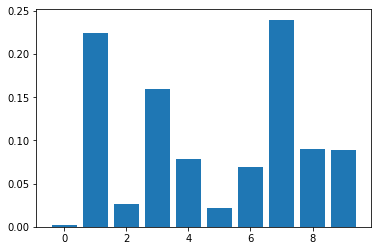

upstream_status        0.239712
status                 0.223820
request_method         0.159552
connection             0.089916
connection_requests    0.089194
request_length         0.078842
request_time           0.068962
body_bytes_sent        0.026485
bytes_sent             0.021510
remote_user            0.002007
dtype: float64

In [66]:
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_
feature_importance = {}

# summarize feature importance
for i,v in enumerate(importance):
    feature_importance[df.columns[i]] = v
    
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()
pd.Series(feature_importance).sort_values(ascending=False)

In [75]:
num_classes = df['rule.mitre.tactic'].nunique()
num_classes

6

In [79]:
# Input layer
inputs = tf.keras.layers.Input(shape=(10, ))

# Hidden layer
dense_1 = tf.keras.layers.Dense(units=32, activation='relu')(inputs)
dense_2 = tf.keras.layers.Dense(units=64, activation='relu')(dense_1)
dropout_1 = tf.keras.layers.Dropout(0.1)(dense_2)
dense_3 = tf.keras.layers.Dense(units=32, activation='relu')(dropout_1)

# Output layer
outputs = tf.keras.layers.Dense(units=1, activation='softmax')(dense_3)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.compile(
    loss=('categorical_crossentropy'),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_22 (Dense)            (None, 32)                352       
                                                                 
 dense_23 (Dense)            (None, 64)                2112      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                                 
 dense_25 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,577
Trainable params: 4,577
Non-trainable p

In [83]:
df['rule.mitre.tactic'].unique()

array([0, 1, 2, 3, 4, 5])

In [ ]:
# For label array(['["non-attack"]', '["Impact"]', '["Defense Evasion"]',
#      '["Reconnaissance"]', '["Credential Access"]',
#      '["Initial Access"]'], dtype=object)

# Read data
df = pd.read_csv('../self/df_pre.csv')
class_num = df['rule.mitre.tactic'].nunique()

# Drop unnecessary column
df.drop(['hostname', 'agent.ip'], axis=1, inplace=True)

# Encode categorical column
encode_remote_user = {
    '-': 0,
    'GapuraUb2020-Mobile': 1,
    'google-oauth-client': 2
}

encode_req_method = {
    'GET': 0,
    'POST': 1,
    'HEAD': 2
}

encode_label = {
    '["non-attack"]': 0,
    '["Impact"]': 1,
    '["Defense Evasion"]': 2,
    '["Reconnaissance"]': 3,
    '["Credential Access"]': 4,
    '["Initial Access"]': 5
}

df['remote_user'] = df['remote_user'].apply(lambda x: encode_remote_user[x])
df['request_method'] = df['request_method'].apply(lambda x: encode_req_method[x])

def encode_non_attack(label, to):
    if to == 'non-attack':
        if label == '["non-attack"]':
            return 1
        else:
            return 0
        
    if to == 'impact':
        if label == '["Impact"]':
            return 1
        else:
            return 0
        
    if to == 'defense':
        if label == '["Defense Evasion"]':
            return 1
        else:
            return 0
        
    if to == 'recon':
        if label == '["Reconnaissance"]':
            return 1
        else:
            return 0
    
    

    return 0

def do_train():
    for label in df['rule.mitre.tactic'].unique():
        # check binary model for each label
        df['rule.mitre.tactic'] = df['rule.mitre.tactic'].apply(lambda x: encode_label[x])
        
        

    # Split train
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    
    
    
    return